<a href="https://colab.research.google.com/github/tedteske/Covid-19-Model/blob/master/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This set of functions plots the path of the Covid-19 pandemic and provides tools for constructing what-if scenarios. We make use of the following publicly available datasets: 

For country-level case and population data, see https://ourworldindata.org/coronavirus-source-data. Data files:
* https://covid.ourworldindata.org/data/owid-covid-data.csv
* https://covid.ourworldindata.org/data/ecdc/locations.csv

For U.S. state-level case and population data
* https://github.com/nytimes/covid-19-data
* https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html


We forecast each day's new confirmed cases according to the formula:

$ c_t = contagious_{t-1} \times R_{0,t}/days_{contagious} \times (1 - immune_{t-1}) $

where
* $ c_t = \text{new confirmed casess at time t} $
* $ C_t = \text{cumulative confirmed cases at time t} $
* $ contagious_t = C_t - C_{t - days_{contagious}}$
* $ R_{0,t} = \text{basic reproduction number} \geq 0$
* $ days_{contagious} = \text{number of days each case is assumed to be contagious} = 14 \text{, by default}$
* $ immune = \text{fraction of the population that is immune} = prevalence/(1 - unreported)$
* $ prevalance = \text{cumulative confirmed cases as a fraction of the total population} = C_t/population$
* $ unreported = \text{fraction of all cases that are not reported} $


Given historical data to time $t-1$, all of the above terms are endogenous to the model except for the [basic reproduction number](https://en.wikipedia.org/wiki/Basic_reproduction_number) $R_{0,t}$ and the assumed constant $ days_{contagious}$.

We assume that the path of $R_0$ follows an S-shaped curve from the most recent $R_0$ to some target. 

$R_{0,t}=f(x)= \frac{R_{0,target}-R_{0,t-1}}{1 + e^{(-k \times (x - offset)}}+R_{0,t-1}$

where
* $R_{0,target} = \text{assumed target basic reproduction number}$
* $e = \text{base of the natural logarithm} \approx 2.71828$
* $offset = x \text{ value of the sigmoid's midpoint, default 0}$
* $k = \text{logistic growth rate or steepness of the curve, default 1}$
* $x = \text{real number in the closed interval -6 to 6}$

This is adapted from logistic curve as described at https://en.wikipedia.org/wiki/Logistic_function.

To generate a path for $R_0$, we evenly divide the closed interval -6 to 6 by the number of days we assume it will take to get from $R_{0,t-1}$ to $R_{0,target}$ and plug results into the formula as $x$. Rather than merely assuming the number of days, we can take the average daily rate of progress toward in $R_{0,target}$ over the last several days, say one week.

$r_\Delta = \overline{\% \Delta (R_{0,target} - R_{0,t})}$

and calculate the number of days to get from $R_{0,t-1}$ to $R_{0,target}$:

$days = \log_{1+r_\Delta}(2)=\ln(2)/\ln(1+r\Delta) \text{, rounded}$

This assumes that recent daily percent progess holds in the near future.


## Loading Functions and Data. Run these first.

Run imports and functions.

In [103]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import pandas as pd
import math
from datetime import date
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'
sns.set(style='darkgrid') 
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = [13, 13/1.6]


def load_df(covid_data, pop_data, case_start=10, contagious_days=14):
    '''
    Loads covid_data into new dataframe, merges population and continent fields 
    from pop_data, and passes to munge_data() and order_columns() for
    further processing. This is the first function called after importing
    CSV files.

    Parameters
    ----------
    covid_data (pd.DataFrame) : raw data from Covid-19 CSV file [1] or similar
    pop_data (pd.DataFrame) : raw data from population CSV file [2] or similar
    case_start (int) : minimum total cases, below which records are not loaded 
    contagious_days (int) : number of days infected person assumed contagious      

    Returns
    -------
    pd.DataFrame
    
    Notes
    ----
    [1] https://covid.ourworldindata.org/data/ecdc/full_data.csv
    [2] https://covid.ourworldindata.org/data/ecdc/locations.csv
    '''
    try:
        population_cols = ['location', 'continent', 'population']
        latest_pops = pop_data[population_cols].groupby('location').max()
        covid_data = covid_data.merge(latest_pops, 
                                      left_on='location', right_on='location')
    except:
        population_cols = ['location', 'population']
        latest_pops = pop_data[population_cols].groupby('location').max()
        covid_data = covid_data.merge(latest_pops, 
                                      left_on='location', right_on='location')
        covid_data['continent'] = 'NA'
    covid_data.rename(columns={'continent': 'region'}, inplace=True) 
    df = munge_data(covid_data, case_start, contagious_days)
    df = order_columns(df)
    return df


def munge_data(df, case_start, contagious_days):
    '''
    Indexes dataframe by location and date, and creates all calculated fields.

    Parameters
    ----------
    df (pd.DataFrame) : dataframe to be processed
    case_start (int) : minimum total cases, below which records are not loaded 
    contagious_days (int) : number of days infected person assumed contagious      

    Returns
    -------
    pd.DataFrame
    '''

    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['contagious_days'] = contagious_days

    df.set_index(['location', 'date'], inplace=True)
    df['day'] = df.index.get_level_values('date').day_name().str.slice(stop=3)
    df.index.names = ['location', None]
    
    df['source'] = 'actual'
    df['prevalence'] = df['total_cases']/df['population']       
    
    df['contagious'] = (df['total_cases'] 
                        - df['total_cases'].shift(contagious_days))
    df.loc[df['contagious'] < 0, 'contagious'] = df.loc[df['contagious'] < 0, 
                                                        'total_cases']
    
    df['R_zero'] = df['new_cases']/df['contagious'] * contagious_days
    
    np.seterr(divide = 'ignore') 
    '''
    Otherwise, get "RuntimeWarning: divide by zero encountered in log result".
    Warning happens when np.log(0), for example when total_cases declines 100%.
    As total_cases is cumulative and gross of recovered, this example could 
    only happen with a reporting agency error. 
    
    Better to ignore this RuntimeWarning, and leave the public data unaltered.
    '''
    df['growth'] = np.log(1 + df['total_cases'].pct_change())
    df['days_to_dbl'] = np.log(2)/df['growth']
    df.loc[df.groupby('location').head(1).index,
           ['growth', 'days_to_dbl']] = np.NaN
    np.seterr(divide = 'warn') 
    
    df['fatality'] = df['total_deaths']/df['total_cases']
    
    return df


def order_columns(df):
    '''
    Re-orders dataframe columns after each load and forecast.
    '''

    column_names = ['day', 'new_cases',  'total_cases', 'prevalence', 
                    'growth', 'days_to_dbl', 'contagious', 'R_zero',  
                    'new_deaths', 'total_deaths', 'fatality', 
                    'total_tests', 'new_tests',
                    'source', 'population', 'region']
    return df.reindex(columns=column_names)
   

def create_R_zero_path(days, last, move=[]):
    '''
    Creates a path of future reproduction numbers to be used in forecast().

    Parameters
    ----------
    days (int) : number of days forecasted
    last (float) : starting reproduction number 
    move[0] (float) : target reproduction number 
    move[1] (float) : daily rate of change from last to target       
    move[2] (float) : default 0; offset or x_0, 
                    the x value of the sigmoid's midpoint [1]
    move[3] (float) : default 1; k, the logistic growth rate 
                    or steepness of the curve [1]

    Returns
    -------
    pd.Series: series of forecast reproduction numbers
    
    Notes
    -----
    [1] https://en.wikipedia.org/wiki/Logistic_function
    [2] https://en.wikipedia.org/wiki/Sigmoid_function
    [3] https://ibguides.com/biology/notes/populations/
    '''
    
    if isinstance(move, (int, float)):
        move = [move]

    move_full_spec = [last, None, 0, 1]
    move_full_spec[:len(move)] = move
    target, rate, offset, k = move_full_spec
    
    if rate:
        days_motion = int(round(np.log(2)/np.log(1 + rate)))
    else:
        days_motion = days
    
    L = target - last

    y = []
    for x in np.linspace(-6, 6, days_motion):
        fx = L / (1 + math.e**(-k * (x - offset)))
        fx += last
        y.append(fx)
    
    days_flat = max(days - days_motion, 0)
    flat_values = np.ones(days_flat) * y[-1]
    y = y + list(flat_values)
    return pd.Series(y)


def forecast(df, days, R_zero_move=[], R_zero_trailing=1, 
             new_R_zeros=None, new_fatality=None,
             unreported=0.0, contagious_days=14, replace=True):
    '''
    Forecasts reproduction numbers.

    Parameters
    ----------
    df (pd.DataFrame) : dataframe of inputs to forecast
    days (int) : number of days forecasted
    R_zero_move (list of floats) : parameters for reproduction number motion
        see create_R_zero_path() docstring for details on list items
    R_zero_trailing (int > 0) : number of most recent R_zero 
        over which to average
    new_R_zeros (None or list or Series of floats) : forward path of R-zero;
        if not None, ignore R_zero_move and R_zero_trailing
    new_fatality (float) : forward case fatality rate; if None, uses last
    unreported (float) : portion of total contagious that goes unreported, 
        between 0 and 1
    contagious_days (int) : number of days infected person assumed contagious
    replace (bool) : if True, replace existing forecast records

    Returns
    -------
    pd.DataFrame: dataframe with appended forecast records
    '''

    if replace:
        df = df[df['source'] != 'forecast']
    
    if days > 0:        
        
        if new_R_zeros is None:
            last_R_zero = df['R_zero'][-R_zero_trailing:].mean()
            new_R_zeros = create_R_zero_path(days, last_R_zero, R_zero_move)
        
        for i in range(days):

            last = df.iloc[-1]
            R_zero_ = new_R_zeros[i]  
            trans_rate = last['R_zero']/contagious_days

            # adjust for herd immunity
            immune = last['prevalence']/(1 - unreported)

            new_cases_ = last['contagious'] * trans_rate * (1 - immune)
            total_cases_ = last['total_cases'] + new_cases_
            prevalence_ = total_cases_/last['population']
            contagious_ = (total_cases_ 
                           - df.iloc[-contagious_days]['total_cases'])
                     
            growth_ = np.log(total_cases_/last['total_cases'])
            days_to_dbl_ = np.log(2)/growth_
            
            if new_fatality is None:
                fatality_ = last['fatality']
            else:
                fatality_ = new_fatality[i]
                  
            total_deaths_ = total_cases_ * fatality_
            new_deaths_ = total_deaths_ - last['total_deaths']

            data = {'source': 'forecast',
                    'new_cases': new_cases_,
                    'total_cases': total_cases_,
                    'prevalence': prevalence_,
                    'R_zero': R_zero_,
                    'contagious': contagious_,
                    'growth': growth_,
                    'days_to_dbl': days_to_dbl_,
                    'new_deaths': new_deaths_,
                    'total_deaths': total_deaths_,
                    'fatality': fatality_,
                    'population': last['population'],
                    'region': last['region']}
            
            next_date = df.index[-1] + pd.Timedelta(days=1)
            df = df.append(pd.DataFrame(data, index=[next_date]))
        
        df['day'] = df.index.day_name().str.slice(stop=3)
        df = order_columns(df)
    return df


def plot_timeline(df, title=None, date_freq='MS',
                  left=[],
                  right=None,
                  left_ylabel=None,
                  right_ylabel=None,
                  left_yscale=1000,
                  right_hline=1.0):
    '''
    Lineplots several user-defined time series.

    Parameters
    ----------
    df (pd.DataFrame) : dataframe with columns to be plotted
    title (str) : plot title
    date_freq (str) : x-axis tick freqency, to prevent cluttering 
        'MS' for month start
        'W' for weekly
        'Q' for quarterly
    left (list of str) : names of columns to be plotted using left axis
    right (str) : name of column to be plotted using right axis, maximum 2
    left_ylabel (str) : left axis label
    right_ylabel (str) : right axis label
    left_yscale (int) : scale of left axis tick labels
    '''
    
    data = df.copy()
    
    fig, ax = plt.subplots()
    fig_width = 20
    fig.figsize = (fig_width, fig_width/1.6)
   
    for column in left:
        sns.lineplot(x=data.index, y=column, style='source', data=data, 
                     legend=False, ax=ax)
    b = min(len(ax.lines)-1, 2)
    
    # configure right axis
    if right:
        ax2 = ax.twinx()
        sns.lineplot(x=data.index, y=right, style='source', data=data,
                     legend=False, ax=ax2, color='g')
        
        yticks = np.arange(data[right].min(), data[right].max(), 0.5)
        yticks = (yticks * 2).round()/2  # limits yticks to multiples of 0.5
        
        ax2.set_yticks(yticks)
        if right_ylabel:        
            ax2.set_ylabel(right_ylabel)
        else:
            ax2.set_ylabel(right)
        handles = [ax.lines[a] for a in [0, b]] + [ax2.lines[0]]
        labels = left + [right]

        if right_hline:
            plt.axhline(right_hline, ls='-', color='gray', alpha=0.7)
    
    else:
        handles = [ax.lines[a] for a in [0, b]] 
        labels = left 
   
    ax.legend(handles, labels, loc=0)

    # configure xticks
    xticks = pd.date_range(start=data.index.min(), 
                           end=data.index.max(),
                           freq=date_freq)
    ax.set_xticks(xticks)

    # configure ylabels, yticks
    if left_ylabel:
        ax.set_ylabel(left_ylabel) 
    else:
        ax.set_ylabel(str(left) + ' (thousands)')
    ax.set_yticklabels(ax.get_yticks()/left_yscale)

    plt.title(title)
    plt.show()


def plot_cdr(df, title=None, date_freq='MS',
             left=['total_deaths', 'new_cases'],
             right='R_zero',
             left_ylabel='cases, deaths (thousands)',
             right_ylabel='reproduction number (or R-zero)',
             left_yscale=1000):
    '''
    Lineplots time series of Total Deaths, New Cases, and Reproduction Numbers,
    appropriately scaled, using plot_timeline().

    Parameters
    ----------
    df (pd.DataFrame) : dataframe with columns to be plotted
    title (str) : plot title
    date_freq (str) : x-axis tick freqency, to prevent cluttering 
        'MS' for month start
        'W' for weekly
        'Q' for quarterly
    left (list of str) : names of columns to be plotted using left axis
    right (str) : name of column to be plotted using right axis
    left_ylabel (str) : left axis label
    right_ylabel (str) : right axis label
    left_yscale (int) : scale of left axis tick labels
    '''
    
    plot_timeline(df, title=title, date_freq=date_freq,
                  left=left,
                  right=right,
                  left_ylabel=left_ylabel,
                  right_ylabel=right_ylabel,
                  left_yscale=left_yscale)


def plot_growth(df, locations, column='total_cases', title=None, 
                start=10, ascending=True, rolling=1, logy=True,
                min_cases=10, hline=None):
    '''
    Lineplots several user-defined time series.

    Parameters
    ----------
    df (pd.DataFrame) : dataframe with columns to be plotted
    locations (list of str) : names of locations to be plotted
    column (str) : name of column to be plotted for each location
    title (str) : plot title
    start (int) : starting value for the plotted column
    ascending (bool) : if True, plot values above start; if False, below
    rolling (int) : days over which to apply a rolling mean
    logy (bool) : if True, configure y-axis as a log(10) scale
    min_cases (int) : minimum threshold total_cases; 
                      ignored if column='total_cases'
    hline (float or None) : if float, plot horizontal line

    Note
    ----
    The parameter min_cases is especially useful when plotting R_zero, as
    early R_zero values are highly variable.
    '''
    
    data = df.copy()
    
    # apply rolling mean to each location
    data = data.groupby(level=0).rolling(rolling).mean()
    
    # unless plotting total_cases itself, apply a total_cases threshold
    if column != 'total_cases':
        data = data[data['total_cases'] >= min_cases]
    
    if ascending:
        data = data[data[column] >= start]
    else:
        data = data[data[column] <= start]        

    # create column representing days since cutoff values
    data['days_since'] = data.groupby(level=0).cumcount()
    data.loc[data['days_since'] == 0, column] = start
    
    # move location to column, then pivot
    data.reset_index(level=1, inplace=True) 
    pivoted = data.pivot(index='days_since', columns='location', values=column)
    pivoted.index.name = "days since " + column + " = " + str(start) 

    pivoted[locations].plot(logy=logy, title=title or column)

    if hline:
        plt.axhline(hline, ls='-', color='gray', alpha=0.7)
    
    plt.show()

Load country and U.S. state-level data from public sources.

In [104]:
'''
Load country-level data from https://covid.ourworldindata.org
'''

covid_data = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/full_data.csv')
#covid_data = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
pop_data = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/locations.csv')
df = load_df(covid_data, pop_data, case_start=1, contagious_days=14)

In [105]:
'''
Load US state-level data from 
https://github.com/nytimes/covid-19-data
https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html
'''

covid_state_data =  pd.read_csv('https://raw.githubusercontent.com/nytimes/'
                                'covid-19-data/master/us-states.csv')

covid_state_data.rename({'state':'location', 'cases':'total_cases', 
                         'deaths':'total_deaths'}, axis='columns', inplace=True) 
covid_state_data.drop('fips', axis='columns', inplace=True) 

covid_state_data.set_index(['location','date'], inplace=True)
covid_state_data.sort_index(inplace=True)
covid_state_data['new_cases'] = np.nan 
covid_state_data['new_deaths'] = np.nan 

for idx in covid_state_data.index.levels[0]:
    covid_state_data.new_cases[idx] = covid_state_data.total_cases[idx].diff()
    covid_state_data.new_deaths[idx] = covid_state_data.total_deaths[idx].diff()

covid_state_data.reset_index(inplace=True)

pop_state_data = pd.read_csv('http://www2.census.gov/programs-surveys/popest/'
                            'datasets/2010-2019/national/totals/'
                            'nst-est2019-popchg2010_2019.csv')
pop_state_data = pop_state_data[['NAME', 'POPESTIMATE2019']]

pop_state_data.rename({'NAME':'location', 'POPESTIMATE2019':'population'}, 
                      axis='columns', inplace=True) 

df_states = load_df(covid_state_data, pop_state_data,  
                    case_start=10, contagious_days=14)

## United States

This is the last one week.

In [106]:
US_Cov = df[df['total_cases']>100].loc['United States']
US_Cov[US_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-07-02,Thu,52048.0,2686480.0,0.008116,0.019564,35.429387,523190.0,1.392748,652.0,128062.0,0.047669,NaN,NaN,actual,331002647.0,North America
2020-07-03,Fri,53399.0,2739879.0,0.008278,0.019682,35.217364,548827.0,1.362152,678.0,128740.0,0.046987,NaN,NaN,actual,331002647.0,North America
2020-07-04,Sat,54442.0,2794321.0,0.008442,0.019675,35.229156,573360.0,1.329336,694.0,129434.0,0.046320,NaN,NaN,actual,331002647.0,North America
2020-07-05,Sun,45221.0,2839542.0,0.008579,0.016054,43.176980,584423.0,1.083280,242.0,129676.0,0.045668,NaN,NaN,actual,331002647.0,North America
2020-07-06,Mon,49093.0,2888635.0,0.008727,0.017141,40.437257,607723.0,1.130946,271.0,129947.0,0.044986,NaN,NaN,actual,331002647.0,North America
2020-07-07,Tue,49990.0,2938625.0,0.008878,0.017158,40.398577,626323.0,1.117411,359.0,130306.0,0.044343,NaN,NaN,actual,331002647.0,North America
2020-07-08,Wed,57473.0,2996098.0,0.009052,0.019369,35.786438,649076.0,1.239642,1174.0,131480.0,0.043884,NaN,NaN,actual,331002647.0,North America


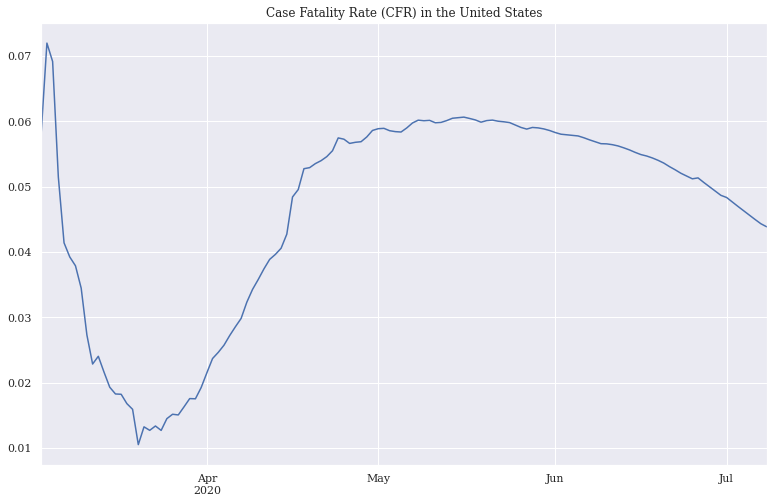

In [107]:
US_Cov[US_Cov['source']=='actual']['fatality'].plot(title='Case Fatality Rate (CFR) in the United States')
plt.show()

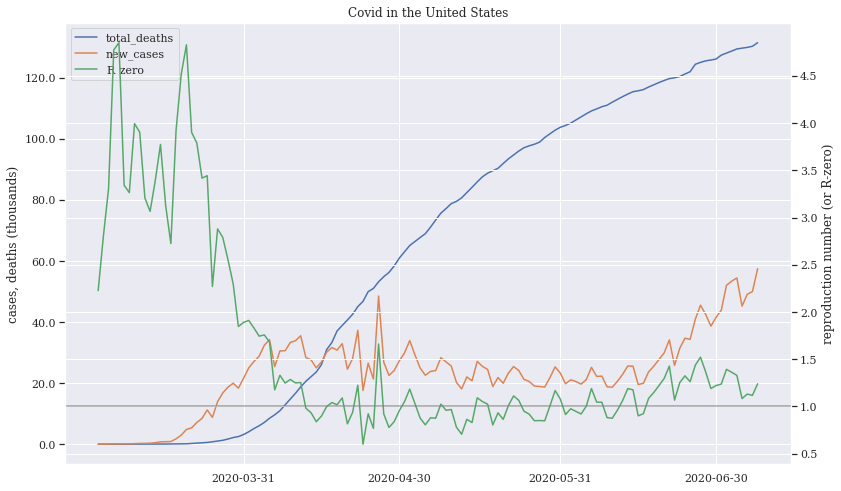

In [108]:
plot_cdr(US_Cov[US_Cov['source']=='actual'], 
         'Covid in the United States','M')

Now let's forecast the next 100 days. Assume a daily percent change in the reproduction number and target of 0.7. Plug this estimate into forecast model, print the results, and plot.



In [109]:
US_Cov = forecast(US_Cov, 100, R_zero_move=[0.7, 0.05, 0], R_zero_trailing=7)
default_scenario = US_Cov.copy()
default_scenario.tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-10-10,Sat,917.121396,4.516933e+06,0.013646,0.000203,3413.486511,17712.775369,0.701327,40.246721,198219.935178,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-10-11,Sun,875.208620,4.517808e+06,0.013649,0.000194,3577.664363,16903.341553,0.701327,38.407432,198258.342610,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-10-12,Mon,835.211325,4.518643e+06,0.013651,0.000185,3749.704279,16130.900211,0.701327,36.652201,198294.994811,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-10-13,Tue,797.042172,4.519440e+06,0.013654,0.000176,3929.981730,15393.761497,0.701327,34.977195,198329.972006,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-10-14,Wed,760.617634,4.520201e+06,0.013656,0.000168,4118.890860,14690.310316,0.701327,33.378750,198363.350756,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-10-15,Thu,725.857877,4.520927e+06,0.013658,0.000161,4316.845339,14019.004370,0.701327,31.853362,198395.204118,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-10-16,Fri,692.686669,4.521620e+06,0.013660,0.000153,4524.279104,13378.371964,0.701327,30.397685,198425.601803,0.043884,NaN,NaN,forecast,331002647.0,North America


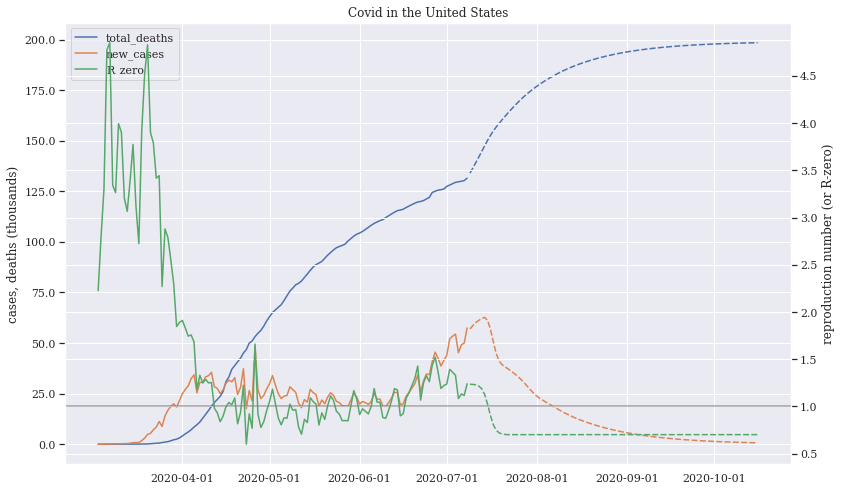

In [110]:
plot_cdr(default_scenario, 'Covid in the United States')

### Scenario: Relax on May 1 

In [111]:
cutoff = date(2020, 4, 30)
US_Cov_old = df[df['total_cases']>100].loc['United States'][:cutoff]

forecast_days = 100
relax_date = date(2020, 5, 1) 
relax_days = 14

last_actual = US_Cov_old[US_Cov_old['source']=='actual'].index.max().date()

stage_1 = (relax_date - last_actual).days # days until start of relaxation period
US_Cov_old = forecast(US_Cov_old, stage_1, R_zero_move=[0.7, 0.05, 0], 
                  R_zero_trailing=7, replace=True)

stage_2 = relax_days # days during relaxation period
US_Cov_old = forecast(US_Cov_old, stage_2, R_zero_move=[1.0, None, 0], replace=False)

stage_3 = forecast_days - stage_1 - stage_2 # days during retrenchment
US_Cov_old = forecast(US_Cov_old, stage_3, R_zero_move=[0.7, 0.10,  0], replace=False)

relax_scenario = US_Cov_old.copy()
relax_scenario.tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-08-02,Sun,718.490855,2.011001e+06,0.006075,0.000357,1939.719514,13793.686812,0.700742,42.122449,117897.522099,0.058626,NaN,NaN,forecast,331002647.0,North America
2020-08-03,Mon,686.220452,2.011687e+06,0.006078,0.000341,2031.646777,13174.208956,0.700742,40.230555,117937.752654,0.058626,NaN,NaN,forecast,331002647.0,North America
2020-08-04,Tue,655.400756,2.012343e+06,0.006080,0.000326,2127.892786,12582.575258,0.700742,38.423711,117976.176364,0.058626,NaN,NaN,forecast,331002647.0,North America
2020-08-05,Wed,625.966457,2.012969e+06,0.006081,0.000311,2228.660359,12017.527259,0.700742,36.698087,118012.874452,0.058626,NaN,NaN,forecast,331002647.0,North America
2020-08-06,Thu,597.854930,2.013567e+06,0.006083,0.000297,2334.162862,11477.861199,0.700742,35.050013,118047.924464,0.058626,NaN,NaN,forecast,331002647.0,North America
2020-08-07,Fri,571.006272,2.014138e+06,0.006085,0.000284,2444.624414,10962.428184,0.700742,33.475976,118081.400440,0.058626,NaN,NaN,forecast,331002647.0,North America
2020-08-08,Sat,545.363311,2.014683e+06,0.006087,0.000271,2560.280001,10470.133423,0.700742,31.972624,118113.373064,0.058626,NaN,NaN,forecast,331002647.0,North America


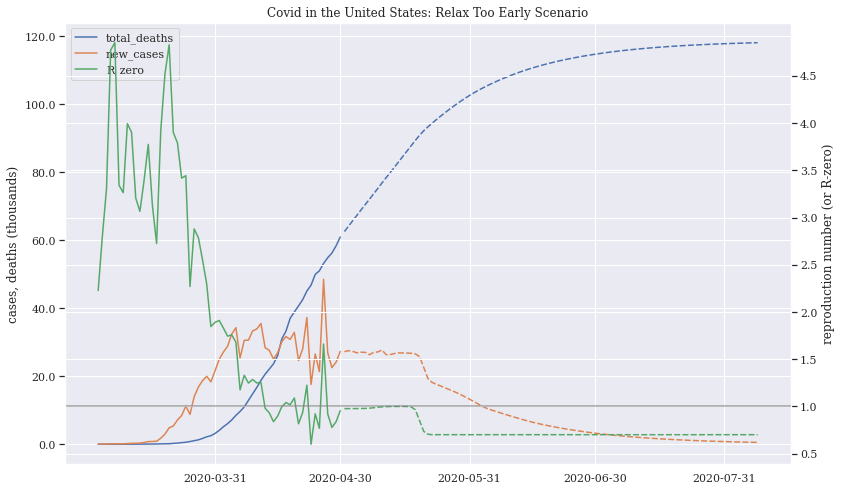

In [112]:
plot_cdr(relax_scenario, 'Covid in the United States: Relax Too Early Scenario','M')

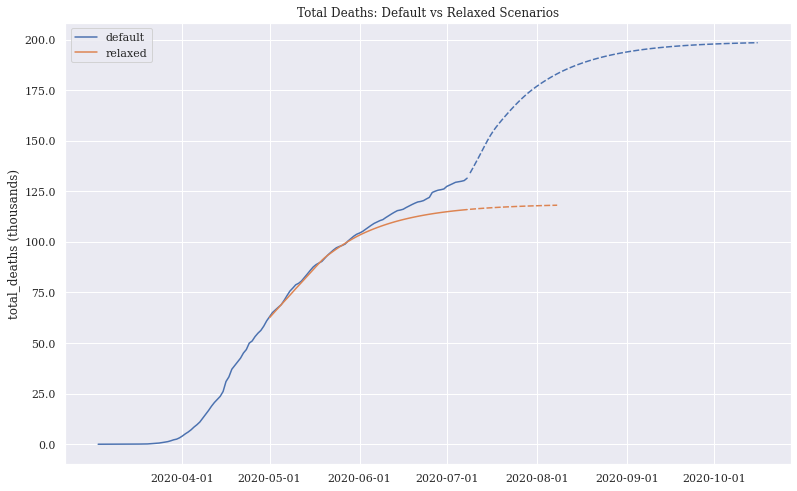

In [113]:
column = 'total_deaths'

relaxed = relax_scenario[relax_scenario['source']=='forecast'][column]
default = default_scenario[[column,'source']]

compare = pd.concat([default, relaxed], axis=1)
compare.columns = ['default','source','relaxed']

plot_timeline(compare, 'Total Deaths: Default vs Relaxed Scenarios',
              date_freq='MS',
              left=['default','relaxed'], right=None,
              left_ylabel=column + ' (thousands)')

Alternately, we can relax and stay relaxed.

In [114]:
forecast_days = 100
relax_date = date(2020, 5, 1) 
relax_days = 7

last_actual = US_Cov[US_Cov['source']=='actual'].index.max().date()

stage_1 = (relax_date - last_actual).days # days until start of relaxation period
US_Cov = forecast(US_Cov, stage_1, R_zero_move=[0.7, 0.05, 0], 
                  R_zero_trailing=7, replace=True)

stage_2 = forecast_days - stage_1 # days during relaxation period
US_Cov = forecast(US_Cov, stage_2, R_zero_move=[1.0, None, 0], replace=False)

US_Cov.tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-12-17,Thu,156472.074304,3.991487e+07,0.120588,0.003928,176.469935,2.446669e+06,1.000911,6866.580576,1.751614e+06,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-12-18,Fri,153827.849839,4.006870e+07,0.121053,0.003846,180.202478,2.406580e+06,1.000848,6750.542104,1.758365e+06,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-12-19,Sat,151217.909749,4.021992e+07,0.121509,0.003767,184.011814,2.366958e+06,1.000789,6636.008159,1.765001e+06,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-12-20,Sun,148642.245879,4.036856e+07,0.121958,0.003689,187.899520,2.327805e+06,1.000735,6522.978383,1.771524e+06,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-12-21,Mon,146100.826026,4.051466e+07,0.122400,0.003613,191.867211,2.289125e+06,1.000684,6411.451363,1.777935e+06,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-12-22,Tue,143593.595335,4.065825e+07,0.122834,0.003538,195.916535,2.250918e+06,1.000637,6301.424691,1.784236e+06,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-12-23,Wed,141120.477634,4.079938e+07,0.123260,0.003465,200.049175,2.213187e+06,1.000593,6192.895025,1.790429e+06,0.043884,NaN,NaN,forecast,331002647.0,North America


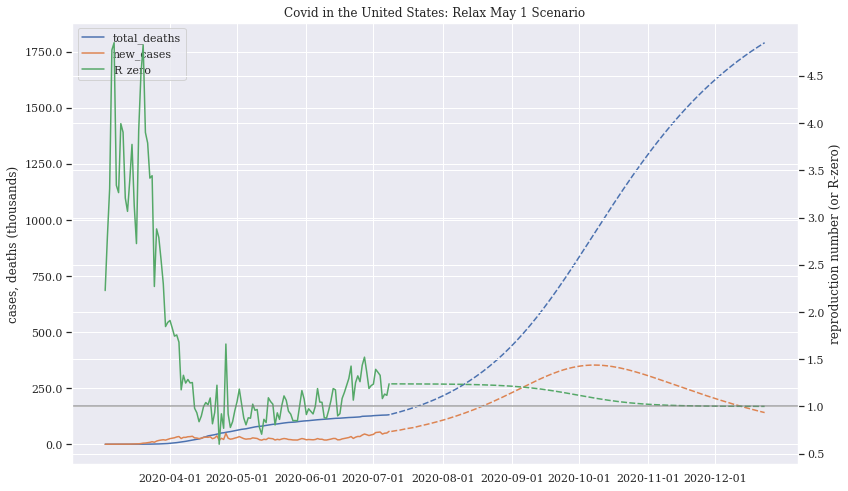

In [115]:
plot_cdr(US_Cov, 'Covid in the United States: Relax May 1 Scenario')

### Scenario: No Further Improvements on Today's Reproduction Number

In [116]:
US_Cov = forecast(US_Cov, 100)
no_improvements_scenario = US_Cov.copy()
no_improvements_scenario.tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-10-10,Sat,562819.775797,2.552935e+07,0.077127,0.022293,31.093108,7.006933e+06,1.239642,24698.639404,1.120324e+06,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-10-11,Sun,572582.518418,2.610194e+07,0.078857,0.022181,31.250181,7.139856e+06,1.239642,25127.065110,1.145451e+06,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-10-12,Mon,582350.857781,2.668429e+07,0.080617,0.022065,31.413311,7.273478e+06,1.239642,25555.736422,1.171006e+06,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-10-13,Tue,592116.458929,2.727640e+07,0.082405,0.021947,31.582637,7.407711e+06,1.239642,25984.287570,1.196991e+06,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-10-14,Wed,601870.701908,2.787827e+07,0.084224,0.021826,31.758309,7.542461e+06,1.239642,26412.340280,1.223403e+06,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-10-15,Thu,611604.689858,2.848988e+07,0.086071,0.021701,31.940478,7.677632e+06,1.239642,26839.504123,1.250243e+06,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-10-16,Fri,621309.258406,2.911119e+07,0.087949,0.021574,32.129304,7.813119e+06,1.239642,27265.376932,1.277508e+06,0.043884,NaN,NaN,forecast,331002647.0,North America


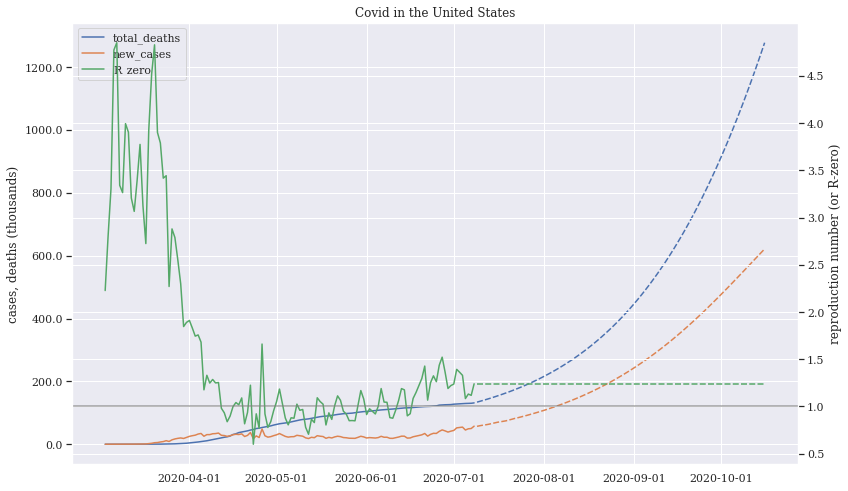

In [117]:
plot_cdr(US_Cov, 'Covid in the United States')

### Scenario: What if 90% of infections go unreported?

In [118]:
US_Cov = forecast(US_Cov, 100, R_zero_move=[0.7, 0.05, 0], R_zero_trailing=7, 
                  unreported=0.9)
unreported_scenario = US_Cov.copy()
unreported_scenario.tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-10-10,Sat,236.968162,4.116694e+06,0.012437,0.000058,12041.250059,5082.533523,0.701327,10.399050,180655.960146,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-10-11,Sun,222.942530,4.116917e+06,0.012438,0.000054,12799.497175,4781.745084,0.701327,9.783553,180665.743699,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-10-12,Mon,209.746998,4.117127e+06,0.012438,0.000051,13605.449778,4498.756649,0.701327,9.204484,180674.948183,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-10-13,Tue,197.332533,4.117324e+06,0.012439,0.000048,14462.102503,4232.515667,0.701327,8.659691,180683.607873,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-10-14,Wed,185.652930,4.117510e+06,0.012440,0.000045,15372.642166,3982.030641,0.701327,8.147146,180691.755019,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-10-15,Thu,174.664662,4.117685e+06,0.012440,0.000042,16340.460036,3746.368201,0.701327,7.664939,180699.419958,0.043884,NaN,NaN,forecast,331002647.0,North America
2020-10-16,Fri,164.326760,4.117849e+06,0.012441,0.000040,17369.163859,3524.650192,0.701327,7.211274,180706.631232,0.043884,NaN,NaN,forecast,331002647.0,North America


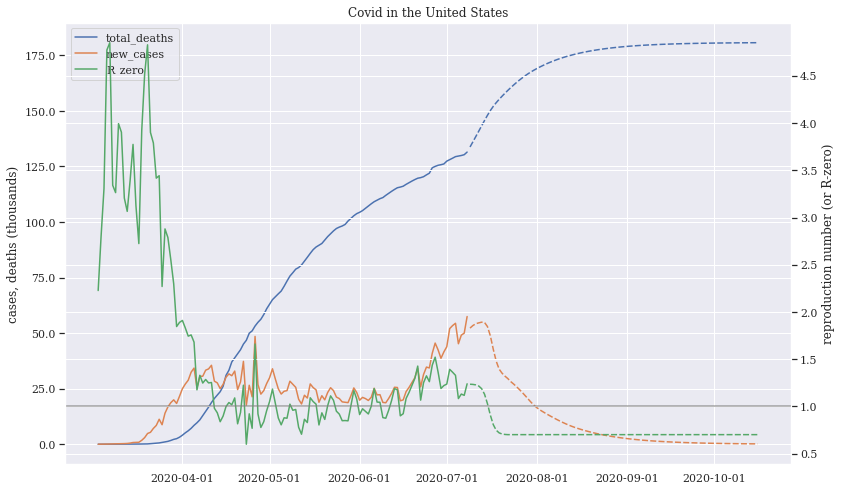

In [119]:
plot_cdr(unreported_scenario, 'Covid in the United States')

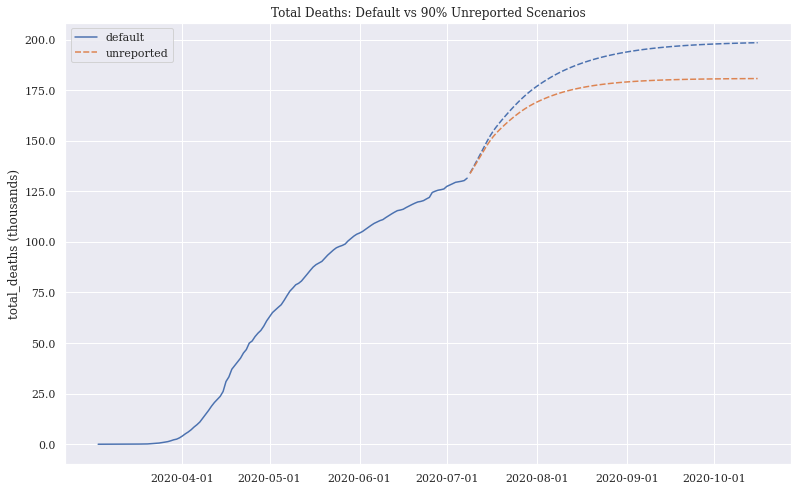

In [120]:
column = 'total_deaths'

unreported = unreported_scenario[unreported_scenario['source']=='forecast'][column]
default = default_scenario[[column,'source']]

compare = pd.concat([default, unreported], axis=1)
compare.columns = ['default','source','unreported']

plot_timeline(compare, 'Total Deaths: Default vs 90% Unreported Scenarios',
              date_freq='MS',
              left=['default','unreported'], right=None,
              left_ylabel=column + ' (thousands)')

### Scenario: What if we had done nothing since some date in the past?

In [121]:
cutoff = date(2020, 3, 15)
US_Cov_old = df[df['total_cases']>10].loc['United States'][:cutoff]
US_Cov_old[US_Cov_old['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-03-09,Mon,121.0,554.0,0.000002,0.246427,2.812790,519.0,3.263969,4.0,21.0,0.037906,NaN,NaN,actual,331002647.0,North America
2020-03-10,Tue,200.0,754.0,0.000002,0.308228,2.248815,701.0,3.994294,5.0,26.0,0.034483,NaN,NaN,actual,331002647.0,North America
2020-03-11,Wed,271.0,1025.0,0.000003,0.307056,2.257400,972.0,3.903292,2.0,28.0,0.027317,NaN,NaN,actual,331002647.0,North America
2020-03-12,Thu,287.0,1312.0,0.000004,0.246860,2.807854,1253.0,3.206704,2.0,30.0,0.022866,NaN,NaN,actual,331002647.0,North America
2020-03-13,Fri,351.0,1663.0,0.000005,0.237071,2.923802,1603.0,3.065502,10.0,40.0,0.024053,NaN,NaN,actual,331002647.0,North America
2020-03-14,Sat,511.0,2174.0,0.000007,0.267946,2.586895,2108.0,3.393738,7.0,47.0,0.021619,NaN,NaN,actual,331002647.0,North America
2020-03-15,Sun,777.0,2951.0,0.000009,0.305575,2.268335,2882.0,3.774462,10.0,57.0,0.019315,NaN,NaN,actual,331002647.0,North America


In [122]:
US_Cov_old = forecast(US_Cov_old, 100)
US_Cov_old.tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-06-17,Wed,504.878783,3.247941e+08,0.981243,1.554459e-06,4.459089e+05,75608.278187,3.774462,9.751979,6.273556e+06,0.019315,NaN,NaN,forecast,331002647.0,North America
2020-06-18,Thu,382.344121,3.247945e+08,0.981244,1.177189e-06,5.888158e+05,57252.686825,3.774462,7.385163,6.273563e+06,0.019315,NaN,NaN,forecast,331002647.0,North America
2020-06-19,Fri,289.503751,3.247948e+08,0.981245,8.913440e-07,7.776427e+05,43348.241313,3.774462,5.591906,6.273569e+06,0.019315,NaN,NaN,forecast,331002647.0,North America
2020-06-20,Sat,219.184355,3.247950e+08,0.981246,6.748393e-07,1.027129e+06,32819.293439,3.774462,4.233652,6.273573e+06,0.019315,NaN,NaN,forecast,331002647.0,North America
2020-06-21,Sun,165.940335,3.247952e+08,0.981246,5.109078e-07,1.356697e+06,24848.586098,3.774462,3.205218,6.273577e+06,0.019315,NaN,NaN,forecast,331002647.0,North America
2020-06-22,Mon,125.635626,3.247953e+08,0.981247,3.868149e-07,1.791935e+06,18815.400593,3.774462,2.426713,6.273579e+06,0.019315,NaN,NaN,forecast,331002647.0,North America
2020-06-23,Tue,95.129629,3.247954e+08,0.981247,2.928910e-07,2.366570e+06,14248.740484,3.774462,1.837475,6.273581e+06,0.019315,NaN,NaN,forecast,331002647.0,North America


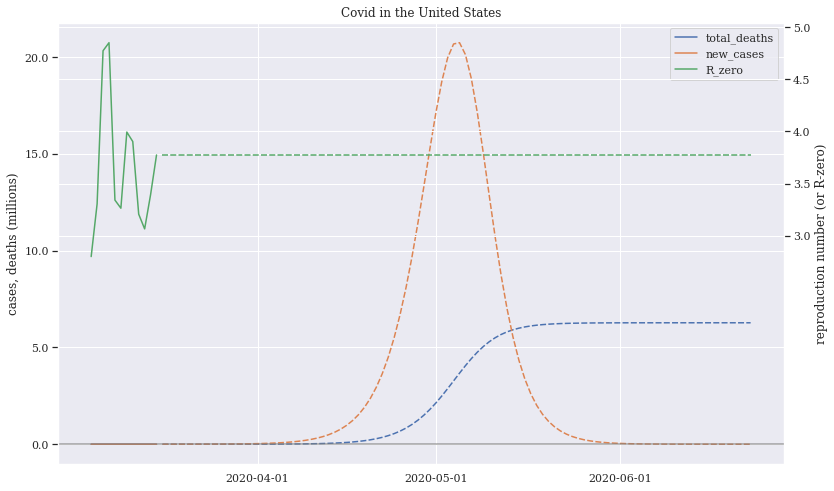

In [123]:
plot_cdr(US_Cov_old.iloc[30:], 'Covid in the United States',left_yscale=1e6,
         left_ylabel='cases, deaths (millions)')

## Other Countries

### China

In [124]:
China_Cov = df[df['total_cases']>100].loc['China']
China_Cov[China_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-07-02,Thu,31.0,84816.0,0.000059,0.000366,1896.104091,358.0,1.212291,0.0,4641.0,0.054718,NaN,NaN,actual,1.439324e+09,Asia
2020-07-03,Fri,14.0,84830.0,0.000059,0.000165,4199.630226,336.0,0.583333,0.0,4641.0,0.054709,NaN,NaN,actual,1.439324e+09,Asia
2020-07-04,Sat,9.0,84839.0,0.000059,0.000106,6533.643826,315.0,0.400000,0.0,4641.0,0.054704,NaN,NaN,actual,1.439324e+09,Asia
2020-07-05,Sun,18.0,84857.0,0.000059,0.000212,3267.341764,304.0,0.828947,0.0,4641.0,0.054692,NaN,NaN,actual,1.439324e+09,Asia
2020-07-06,Mon,14.0,84871.0,0.000059,0.000165,4201.660157,299.0,0.655518,0.0,4641.0,0.054683,NaN,NaN,actual,1.439324e+09,Asia
2020-07-07,Tue,25.0,84896.0,0.000059,0.000295,2353.470331,272.0,1.286765,0.0,4641.0,0.054667,NaN,NaN,actual,1.439324e+09,Asia
2020-07-08,Wed,21.0,84917.0,0.000059,0.000247,2802.509561,264.0,1.113636,0.0,4641.0,0.054653,NaN,NaN,actual,1.439324e+09,Asia


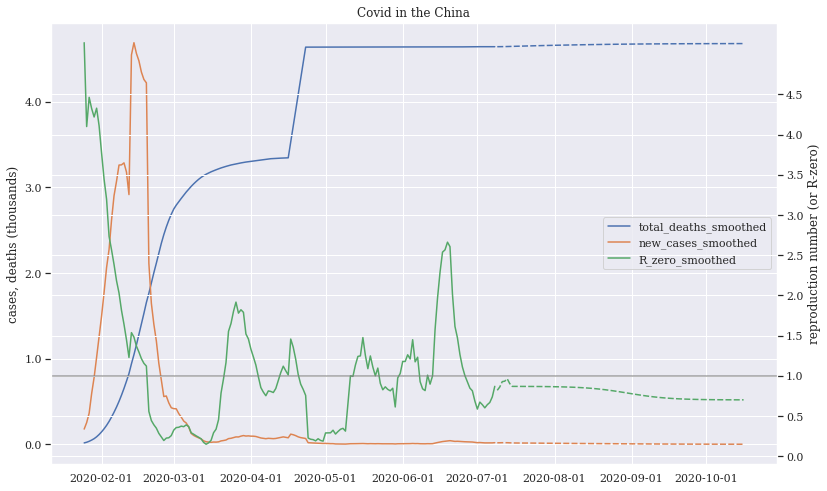

In [125]:
China_Cov = forecast(China_Cov, 100, R_zero_move=0.7, R_zero_trailing=7)

China_Cov['new_cases_smoothed']=China_Cov['new_cases'].rolling(7).mean()
China_Cov['total_deaths_smoothed']=China_Cov['total_deaths'].rolling(7).mean()
China_Cov['R_zero_smoothed']=China_Cov['R_zero'].rolling(7).mean()
plot_cdr(China_Cov, 'Covid in the China',
         left = ['total_deaths_smoothed', 'new_cases_smoothed'],
         right='R_zero_smoothed')

### Italy

In [126]:
Italy_Cov = df[df['total_cases']>100].loc['Italy']
Italy_Cov[Italy_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-07-02,Thu,182.0,240760.0,0.003982,0.000756,916.588082,2932.0,0.869031,21.0,34788.0,0.144492,NaN,NaN,actual,60461828.0,Europe
2020-07-03,Fri,201.0,240961.0,0.003985,0.000835,830.605805,2802.0,1.004283,30.0,34818.0,0.144496,NaN,NaN,actual,60461828.0,Europe
2020-07-04,Sat,223.0,241184.0,0.003989,0.000925,749.321577,3173.0,0.983927,15.0,34833.0,0.144425,NaN,NaN,actual,60461828.0,Europe
2020-07-05,Sun,235.0,241419.0,0.003993,0.000974,711.733792,3144.0,1.046438,21.0,34854.0,0.144371,NaN,NaN,actual,60461828.0,Europe
2020-07-06,Mon,192.0,241611.0,0.003996,0.000795,871.903294,3112.0,0.863753,7.0,34861.0,0.144286,NaN,NaN,actual,60461828.0,Europe
2020-07-07,Tue,208.0,241819.0,0.004000,0.000861,805.500290,3099.0,0.939658,8.0,34869.0,0.144195,NaN,NaN,actual,60461828.0,Europe
2020-07-08,Wed,137.0,241956.0,0.004002,0.000566,1223.822147,3123.0,0.614153,30.0,34899.0,0.144237,NaN,NaN,actual,60461828.0,Europe


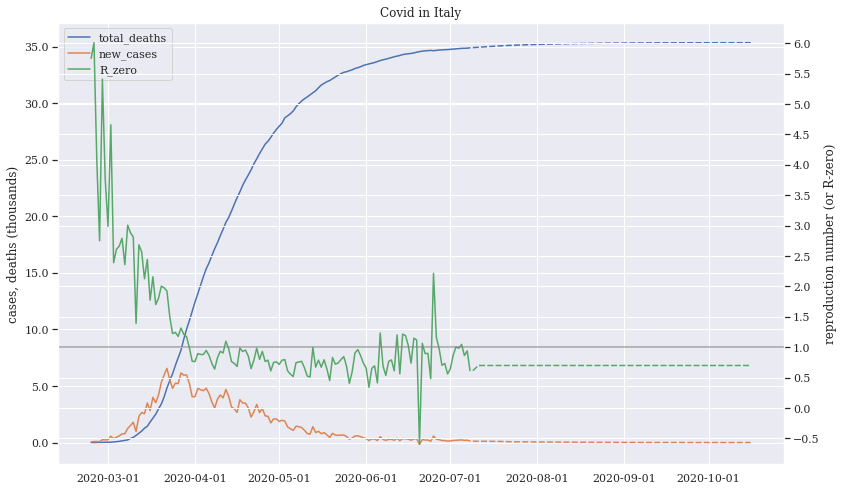

In [127]:
Italy_Cov = forecast(Italy_Cov, 100, R_zero_move=[0.7, 0.3])
plot_cdr(Italy_Cov, 'Covid in Italy')

### Sweden

In [128]:
Sweden_Cov = df[df['total_cases']>1000].loc['Sweden']
Sweden_Cov[Sweden_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-07-02,Thu,1241.0,69692.0,0.006901,0.017967,38.578104,15130.0,1.148315,37.0,5370.0,0.077053,NaN,NaN,actual,10099270.0,Europe
2020-07-03,Fri,947.0,70639.0,0.006994,0.013497,51.356157,14596.0,0.908331,41.0,5411.0,0.076601,NaN,NaN,actual,10099270.0,Europe
2020-07-04,Sat,780.0,71419.0,0.007072,0.010982,63.119303,15376.0,0.710198,9.0,5420.0,0.075890,NaN,NaN,actual,10099270.0,Europe
2020-07-05,Sun,0.0,71419.0,0.007072,0.000000,inf,15376.0,0.000000,0.0,5420.0,0.075890,NaN,NaN,actual,10099270.0,Europe
2020-07-06,Mon,0.0,71419.0,0.007072,0.000000,inf,15376.0,0.000000,0.0,5420.0,0.075890,NaN,NaN,actual,10099270.0,Europe
2020-07-07,Tue,1642.0,73061.0,0.007234,0.022731,30.493786,14129.0,1.627008,13.0,5433.0,0.074363,NaN,NaN,actual,10099270.0,Europe
2020-07-08,Wed,283.0,73344.0,0.007262,0.003866,179.293439,12507.0,0.316783,14.0,5447.0,0.074266,NaN,NaN,actual,10099270.0,Europe


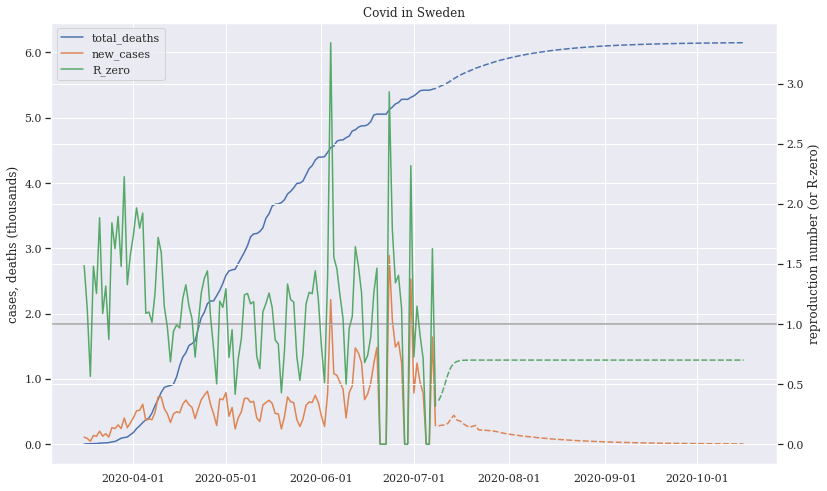

In [129]:
Sweden_Cov = forecast(Sweden_Cov, 100, R_zero_move=[0.7, 0.05,-4])
plot_cdr(Sweden_Cov, 'Covid in Sweden')

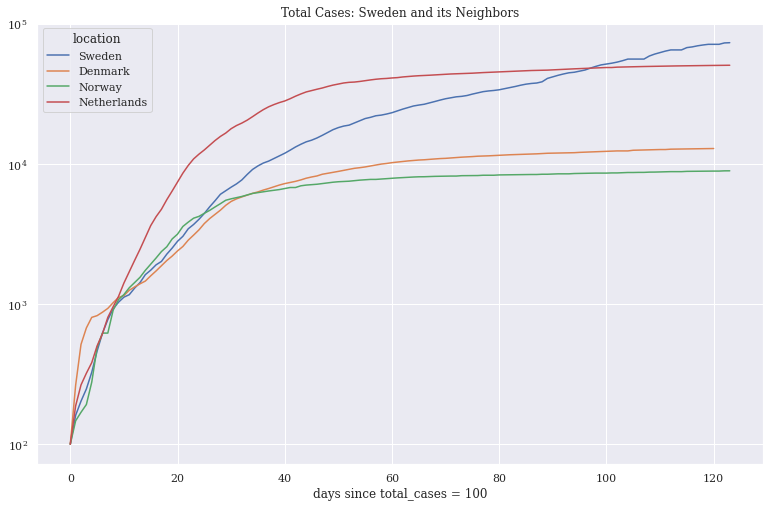

In [130]:
plot_growth(df[df['source']=='actual'], 
            ['Sweden','Denmark','Norway','Netherlands'], 
            title='Total Cases: Sweden and its Neighbors',logy=True, 
            start=100, column='total_cases')

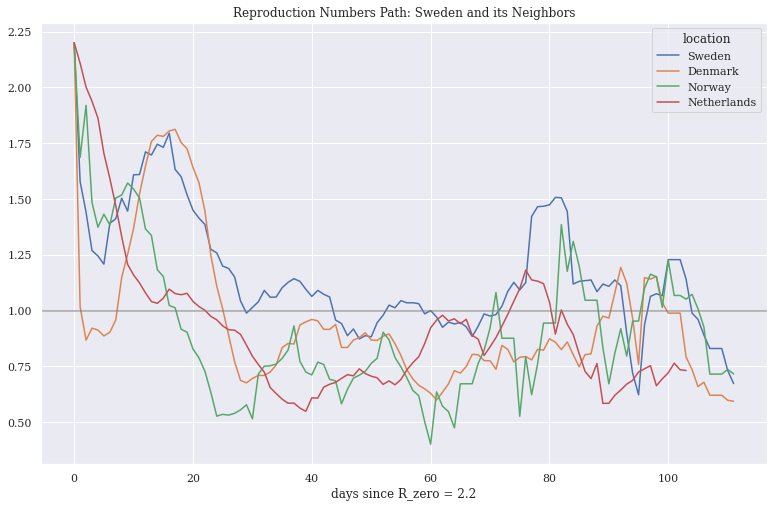

In [131]:
plot_growth(df[df['source']=='actual'],
            locations=['Sweden','Denmark','Norway','Netherlands'], 
            column='R_zero', start=2.2, rolling=7, ascending=False, 
            logy=False, min_cases=100, hline=1,
            title='Reproduction Numbers Path: Sweden and its Neighbors')

What if the United States had followed Sweden's path since Swedens maximum R-zero?

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:228: RuntimeWarning: divide by zero encountered in double_scalars


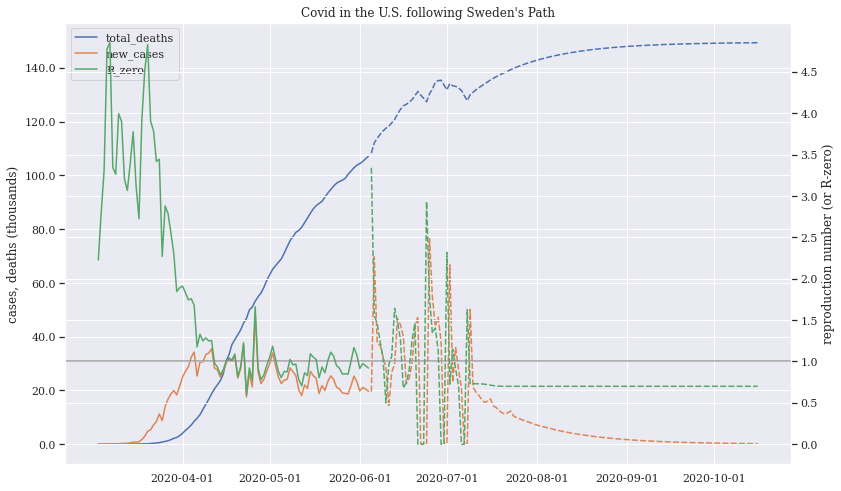

In [132]:
forecast_days=100
cutoff = Sweden_Cov['R_zero'].idxmax(axis=1).date()

US_Cov_Sweden_path = df[df['total_cases']>10].loc['United States'][:cutoff]

new_R_zeros = Sweden_Cov[cutoff:]['R_zero']
new_fatality = US_Cov[cutoff:]['fatality']

last_actual = US_Cov[US_Cov['source']=='actual'].index.max().date()

stage_1 = (last_actual - cutoff).days # days from cutoff until today
US_Cov_Sweden_path = forecast(US_Cov_Sweden_path, stage_1, 
                              new_R_zeros=new_R_zeros,
                              new_fatality=new_fatality)

stage_2 = forecast_days   # days of forward forecast
US_Cov_Sweden_path = forecast(US_Cov_Sweden_path, stage_2, replace=False,
                              R_zero_move=[0.7, 0.05, 0], R_zero_trailing=7)

plot_cdr(US_Cov_Sweden_path.iloc[29:], 'Covid in the U.S. following Sweden\'s Path')

## The World, Country and Regional Comparisons

In [133]:
World_Cov = df.copy()
World_Cov = World_Cov[['new_cases','total_cases','new_deaths',
                       'total_deaths','population']].groupby(level=1).sum()
World_Cov['location']='world'
World_Cov.reset_index(inplace=True)
World_Cov.rename(columns = {'index':'date'}, inplace = True) 
World_Cov = munge_data(World_Cov, case_start=10, contagious_days=14)
World_Cov = order_columns(World_Cov).loc['world']
World_Cov[World_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-07-02,Thu,200215.0,10665506.0,0.001376,0.018951,36.576465,2349792.0,1.192876,4931.0,515965.0,0.048377,NaN,NaN,actual,7.750483e+09,NaN
2020-07-03,Fri,178389.0,10843895.0,0.001399,0.016587,41.787439,2386254.0,1.046597,5143.0,521108.0,0.048055,NaN,NaN,actual,7.750483e+09,NaN
2020-07-04,Sat,206544.0,11050439.0,0.001426,0.018868,36.736835,2415476.0,1.197121,5122.0,526230.0,0.047621,NaN,NaN,actual,7.750483e+09,NaN
2020-07-05,Sun,189605.0,11240044.0,0.001450,0.017013,40.743158,2443087.0,1.086523,4344.0,530574.0,0.047204,NaN,NaN,actual,7.750483e+09,NaN
2020-07-06,Mon,178979.0,11419023.0,0.001473,0.015798,43.875935,2492174.0,1.005430,3380.0,533954.0,0.046760,NaN,NaN,actual,7.750483e+09,NaN
2020-07-07,Tue,175445.0,11594468.0,0.001496,0.015247,45.459909,2531343.0,0.970327,3854.0,537808.0,0.046385,NaN,NaN,actual,7.750483e+09,NaN
2020-07-08,Wed,206641.0,11548979.0,0.001499,-0.003931,-176.326083,2320003.0,1.246970,6087.0,515503.0,0.044636,NaN,NaN,actual,7.703728e+09,NaN


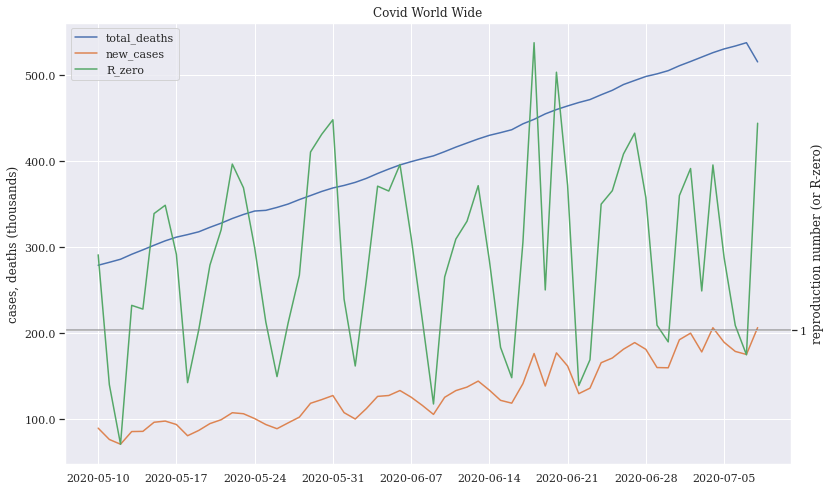

In [134]:
plot_cdr(World_Cov[World_Cov['source']=='actual'][-60:], 
         'Covid World Wide','W')

In [135]:
df[df['source']=='actual'].groupby('location')[['growth','days_to_dbl']]\
    .last().sort_values('growth',ascending=False).head(10)

,growth,days_to_dbl
location,,
Zambia,0.149413,4.639149
Botswana,0.132622,5.226492
Libya,0.122235,5.670632
Nicaragua,0.122053,5.679090
Namibia,0.105567,6.565966
Montenegro,0.075551,9.174585
Zimbabwe,0.069719,9.941981
Madagascar,0.066076,10.490182
Palestine,0.061976,11.184178


In [136]:
df[df['source']=='actual'].groupby('location')[['region','total_cases']]\
    .last().groupby('region').sum()\
    .sort_values('total_cases',ascending=False)

,total_cases
region,
North America,3535435.0
Asia,2683583.0
South America,2600676.0
Europe,2462023.0
Africa,509003.0
Oceania,10389.0


In [137]:
top5 = df[df['source']=='actual']\
    .groupby('location')[['total_cases','R_zero']]\
    .last().sort_values('total_cases', ascending=False).head(5).reset_index()
top5.index += 1
top5

,location,total_cases,R_zero
1,United States,2996098.0,1.239642
2,Brazil,1668589.0,1.213489
3,India,742417.0,1.112824
4,Russia,694230.0,0.943158
5,Peru,309278.0,1.032640


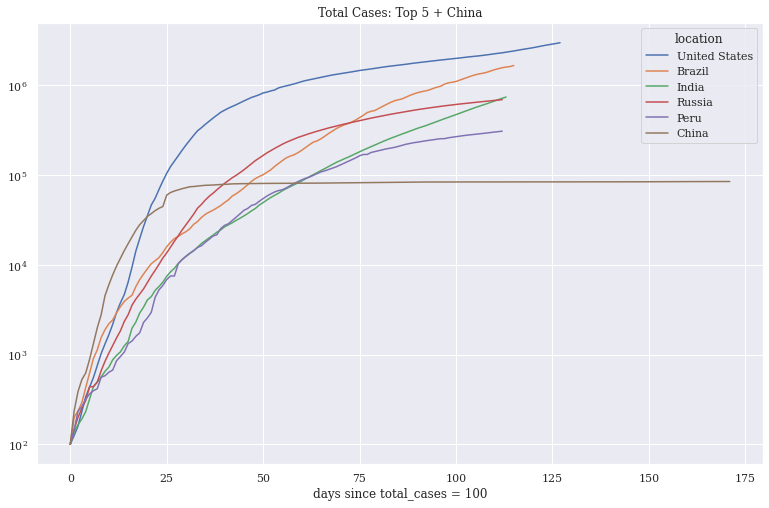

In [138]:
plot_growth(df[df['source']=='actual'], 
            locations=top5['location'].append(pd.Series('China', index=[6])), 
            title='Total Cases: Top 5 + China', 
            start=100, rolling=1, ascending=True, logy=True)

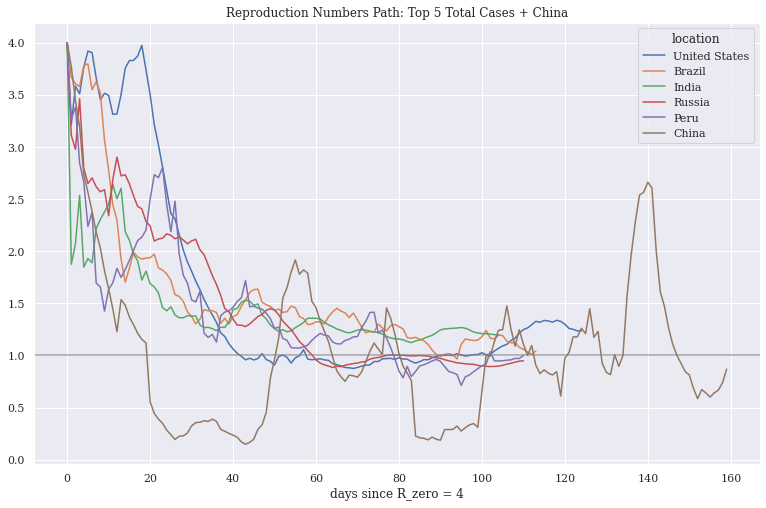

In [139]:
plot_growth(df[df['source']=='actual'],
            locations=top5['location'].append(pd.Series('China', index=[6])), 
            column='R_zero', start=4, rolling=7, ascending=False, 
            logy=False, min_cases=100, hline=1,
            title='Reproduction Numbers Path: Top 5 Total Cases + China')

## U.S. States

### Oklahoma

In [140]:
OK_Cov = df_states[df_states['total_cases']>10].loc['Oklahoma']
OK_Cov[OK_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-07-02,Thu,427.0,14539,0.003674,0.029809,23.252798,5185.0,1.152941,6.0,395,0.027168,NaN,NaN,actual,3956971,NA
2020-07-03,Fri,526.0,15065,0.003807,0.035539,19.503583,5359.0,1.374137,3.0,398,0.026419,NaN,NaN,actual,3956971,NA
2020-07-04,Sat,580.0,15645,0.003954,0.037777,18.348292,5608.0,1.447932,0.0,398,0.025439,NaN,NaN,actual,3956971,NA
2020-07-05,Sun,283.0,15928,0.004025,0.017927,38.664576,5413.0,0.731942,0.0,398,0.024987,NaN,NaN,actual,3956971,NA
2020-07-06,Mon,434.0,16362,0.004135,0.026883,25.783842,5629.0,1.079410,1.0,399,0.024386,NaN,NaN,actual,3956971,NA
2020-07-07,Tue,858.0,17220,0.004352,0.051110,13.561890,6192.0,1.939922,5.0,404,0.023461,NaN,NaN,actual,3956971,NA
2020-07-08,Wed,673.0,17893,0.004522,0.038338,18.079864,6384.0,1.475877,3.0,407,0.022746,NaN,NaN,actual,3956971,NA


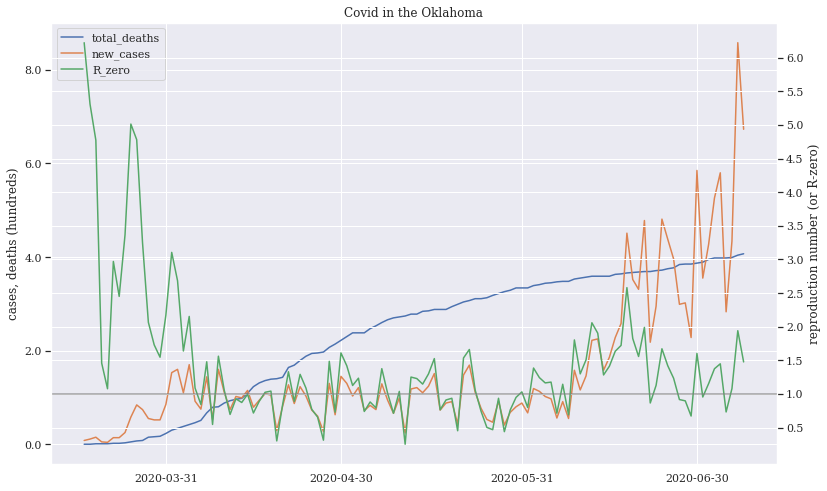

In [141]:
plot_cdr(OK_Cov[OK_Cov['source']=='actual'], 
         'Covid in the Oklahoma','M', left_yscale=100,
         left_ylabel='cases, deaths (hundreds)')

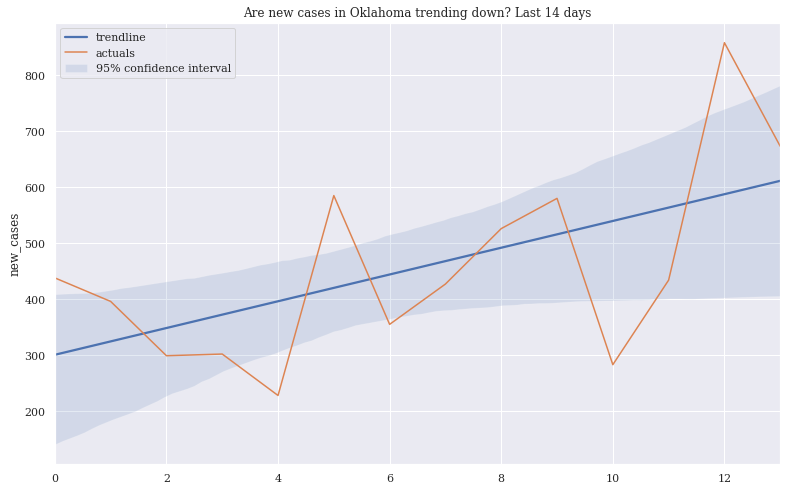

In [142]:
last = 14

OK_last_days = OK_Cov[OK_Cov['source']=='actual'][-last:]
order = 1
x = [a for a in range(last)]
y_col = 'new_cases'

ax0 = sns.regplot(x=x, y=y_col, data=OK_last_days, label='trendline', 
            fit_reg=True, order=order, scatter=False) 
ax0.collections[0].set_label('95% confidence interval')

ax1 = sns.lineplot(x=x, y=y_col, data=OK_last_days, label='actuals')

plt.legend()
plt.title('Are new cases in Oklahoma trending down? Last ' + str(last) + ' days')
plt.show()

In [143]:
OK_Cov = forecast(OK_Cov, 50, R_zero_move=(1.0, 0.05), R_zero_trailing=7)
OK_Cov.tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-08-21,Fri,661.575134,47712.317190,0.012058,0.013963,49.641890,9352.548783,1.000778,15.048403,1085.279891,0.022746,NaN,NaN,forecast,3956971,NA
2020-08-22,Sat,660.497508,48372.814698,0.012225,0.013748,50.416609,9338.269181,1.000778,15.023891,1100.303783,0.022746,NaN,NaN,forecast,3956971,NA
2020-08-23,Sun,659.377626,49032.192324,0.012391,0.013539,51.195985,9323.679544,1.000778,14.998418,1115.302201,0.022746,NaN,NaN,forecast,3956971,NA
2020-08-24,Mon,658.236385,49690.428709,0.012558,0.013335,51.978510,9309.040782,1.000778,14.972459,1130.274660,0.022746,NaN,NaN,forecast,3956971,NA
2020-08-25,Tue,657.092216,50347.520925,0.012724,0.013137,52.762781,9294.517109,1.000778,14.946433,1145.221093,0.022746,NaN,NaN,forecast,3956971,NA
2020-08-26,Wed,655.956710,51003.477635,0.012890,0.012944,53.547877,9280.151123,1.000778,14.920605,1160.141698,0.022746,NaN,NaN,forecast,3956971,NA
2020-08-27,Thu,654.832866,51658.310500,0.013055,0.012757,54.333531,9265.816440,1.000778,14.895041,1175.036739,0.022746,NaN,NaN,forecast,3956971,NA


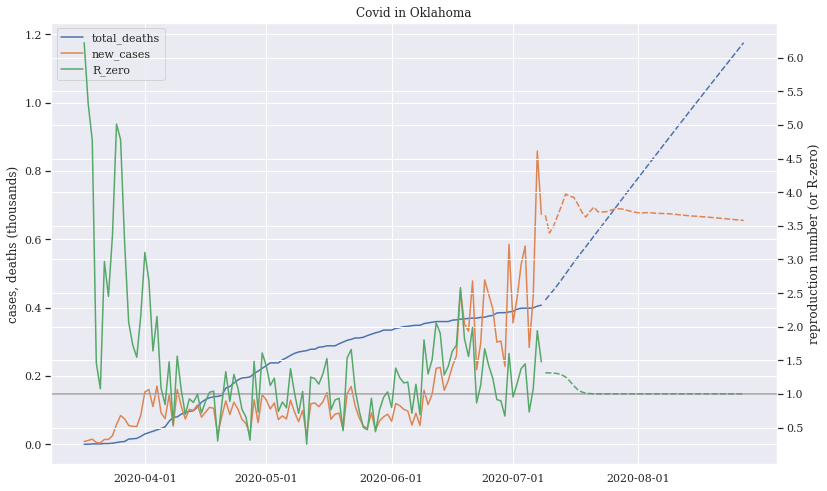

In [144]:
plot_cdr(OK_Cov, 'Covid in Oklahoma')

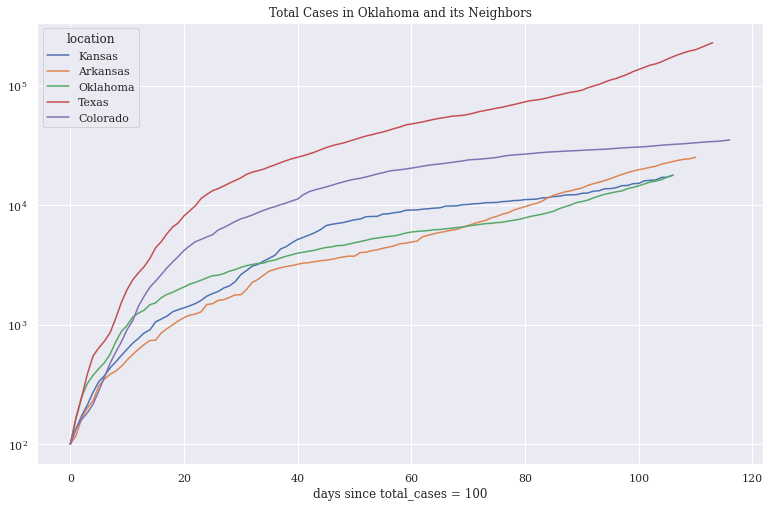

In [145]:
plot_growth(df_states, 
            ['Kansas', 'Arkansas','Oklahoma','Texas','Colorado'],
            title='Total Cases in Oklahoma and its Neighbors', logy=True, 
            start=100, column='total_cases')

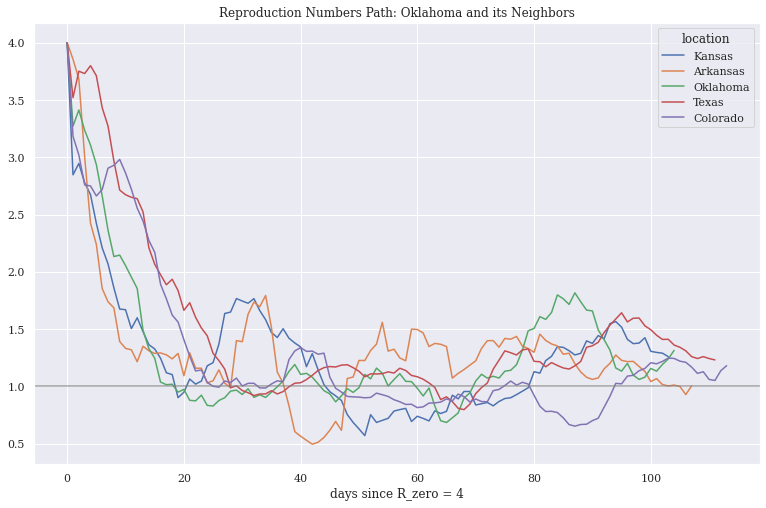

In [146]:
plot_growth(df_states[df_states['source']=='actual'],
            locations=['Kansas', 'Arkansas','Oklahoma','Texas','Colorado'], 
            column='R_zero', start=4, rolling=7, ascending=False, 
            logy=False, min_cases=100, hline=1,
            title='Reproduction Numbers Path: Oklahoma and its Neighbors')

### Colorado

In [147]:
CO_Cov = df_states[df_states['total_cases']>10].loc['Colorado']
CO_Cov[CO_Cov['source']=='actual'].tail(28)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-06-11,Thu,148.0,28632,0.004972,0.005182,133.749006,3516.0,0.589306,10.0,1583,0.055288,NaN,NaN,actual,5758736,NA
2020-06-12,Fri,175.0,28807,0.005002,0.006093,113.753022,3205.0,0.764431,12.0,1595,0.055368,NaN,NaN,actual,5758736,NA
2020-06-13,Sat,195.0,29002,0.005036,0.006746,102.743573,2918.0,0.935572,3.0,1598,0.055100,NaN,NaN,actual,5758736,NA
2020-06-14,Sun,113.0,29115,0.005056,0.003889,178.245947,2751.0,0.575064,1.0,1599,0.054920,NaN,NaN,actual,5758736,NA
2020-06-15,Mon,169.0,29284,0.005085,0.005788,119.760323,2721.0,0.869533,6.0,1605,0.054808,NaN,NaN,actual,5758736,NA
2020-06-16,Tue,143.0,29427,0.005110,0.004871,142.291202,2653.0,0.754617,12.0,1617,0.054950,NaN,NaN,actual,5758736,NA
2020-06-17,Wed,231.0,29658,0.005150,0.007819,88.645871,2612.0,1.238132,14.0,1631,0.054994,NaN,NaN,actual,5758736,NA
2020-06-18,Thu,228.0,29886,0.005190,0.007658,90.509987,2540.0,1.256693,7.0,1638,0.054808,NaN,NaN,actual,5758736,NA
2020-06-19,Fri,286.0,30172,0.005239,0.009524,72.777480,2571.0,1.557371,5.0,1643,0.054454,NaN,NaN,actual,5758736,NA
2020-06-20,Sat,162.0,30334,0.005267,0.005355,129.442787,2500.0,0.907200,4.0,1647,0.054296,NaN,NaN,actual,5758736,NA


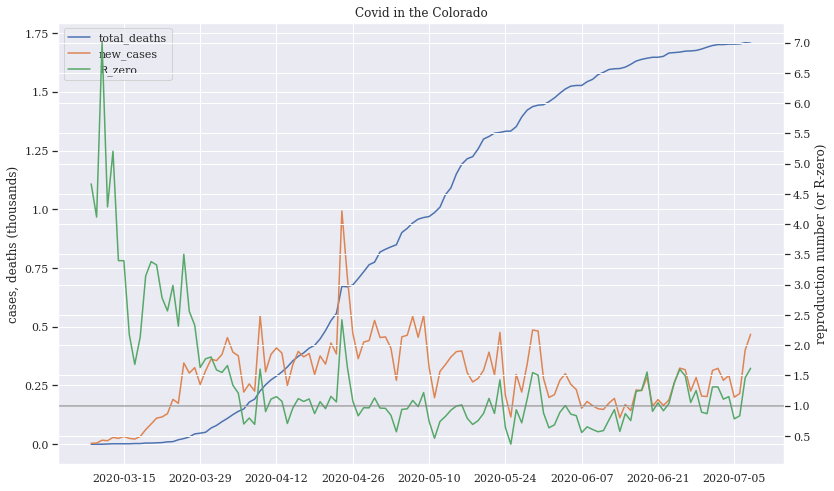

In [148]:
plot_cdr(CO_Cov[CO_Cov['source']=='actual'], 
         'Covid in the Colorado','2W')

### New York

In [149]:
NY_Cov = df_states[df_states['total_cases']>10].loc['New York']
NY_Cov[NY_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-07-02,Thu,872.0,399642,0.020543,0.002184,317.326151,9106.0,1.340655,23.0,31814,0.079606,NaN,NaN,actual,19453561,NA
2020-07-03,Fri,919.0,400561,0.020591,0.002297,301.772693,9231.0,1.393782,22.0,31836,0.079479,NaN,NaN,actual,19453561,NA
2020-07-04,Sat,725.0,401286,0.020628,0.001808,383.308852,9249.0,1.097416,24.0,31860,0.079395,NaN,NaN,actual,19453561,NA
2020-07-05,Sun,536.0,401822,0.020655,0.001335,519.283548,9120.0,0.822807,35.0,31895,0.079376,NaN,NaN,actual,19453561,NA
2020-07-06,Mon,516.0,402338,0.020682,0.001283,540.117403,9081.0,0.795507,16.0,31911,0.079314,NaN,NaN,actual,19453561,NA
2020-07-07,Tue,590.0,402928,0.020712,0.001465,473.023523,9073.0,0.910393,23.0,31934,0.079255,NaN,NaN,actual,19453561,NA
2020-07-08,Wed,691.0,403619,0.020748,0.001713,404.526514,9189.0,1.052780,11.0,31945,0.079146,NaN,NaN,actual,19453561,NA


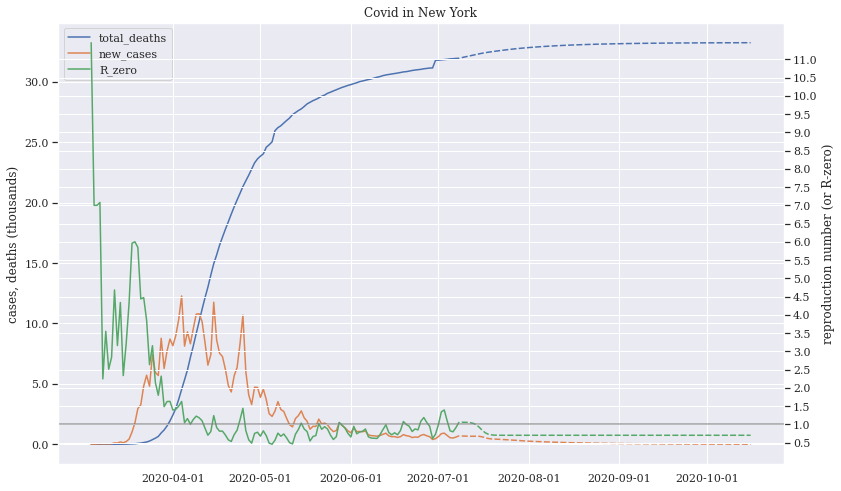

In [150]:
NY_Cov = forecast(NY_Cov, 100, R_zero_move=(0.7,0.05), R_zero_trailing=7)
plot_cdr(NY_Cov, 'Covid in New York')

## More on Reproduction Numbers

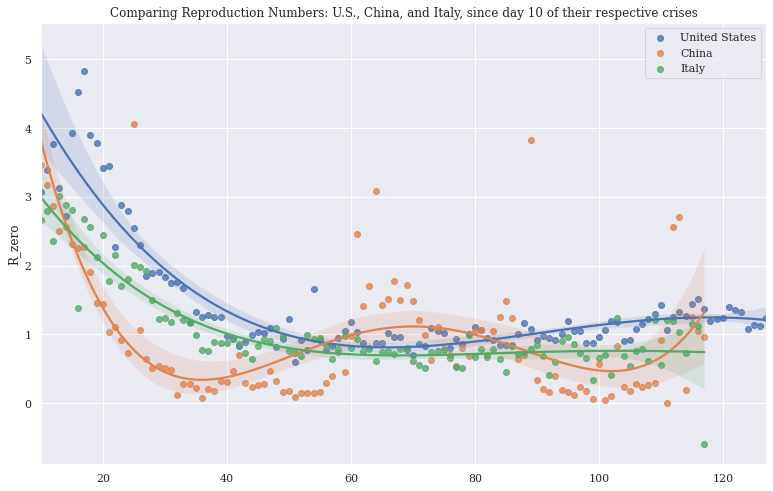

In [151]:
order = 4
day_start = 10

US_ = US_Cov[US_Cov['source']=='actual'].copy()
US_.reset_index(inplace=True)
US_ = US_[day_start:]
days = len(US_)

China_ = China_Cov[China_Cov['source']=='actual'][:days].copy()
China_.reset_index(inplace=True)
China_ = China_[day_start:]

Italy_ = Italy_Cov[Italy_Cov['source']=='actual'][:days].copy()
Italy_.reset_index(inplace=True)
Italy_ = Italy_[day_start:]

sns.regplot(x=US_.index, y='R_zero', data=US_, label='United States', 
            fit_reg=True, order=order) 
sns.regplot(x=China_.index, y='R_zero', data=China_,  label='China',
            fit_reg=True, order=order) 
sns.regplot(x=China_.index, y='R_zero', data=Italy_, label='Italy',
            fit_reg=True, order=order) 

plt.legend()
plt.title('Comparing Reproduction Numbers: U.S., China, and Italy, since day '
          + str(day_start) + ' of their respective crises')
plt.show()

#### First stab at an ARIMA model of the U.S. reproduction number. 

Following steps in https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

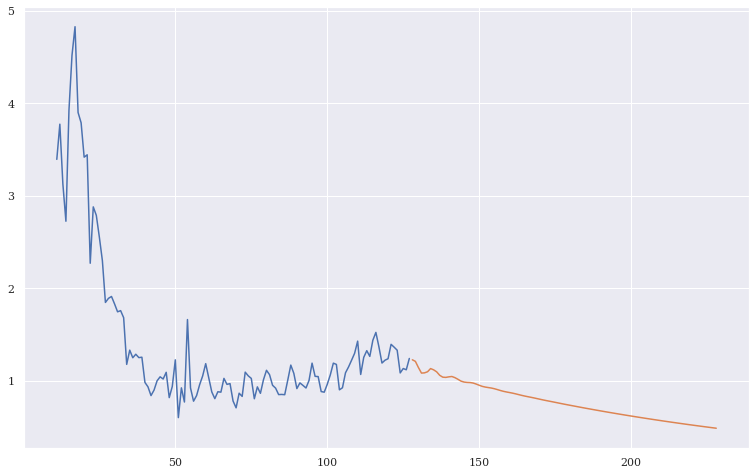

In [152]:
from statsmodels.tsa.arima_model import ARIMA

actuals = np.log(US_.R_zero)[1:]

# fit model
model = ARIMA(actuals, order=(7, 1, 1))
model_fit = model.fit(disp=False)

# make prediction
prediction = model_fit.predict(len(actuals), len(actuals)+100, typ='levels')

# plot results
sns.lineplot(data=np.exp(actuals))
sns.lineplot(data=np.exp(prediction))

In [153]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.R_zero   No. Observations:                  116
Model:                 ARIMA(7, 1, 1)   Log Likelihood                  56.331
Method:                       css-mle   S.D. of innovations              0.148
Date:                Thu, 09 Jul 2020   AIC                            -92.663
Time:                        11:24:41   BIC                            -65.127
Sample:                             1   HQIC                           -81.485
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0086      0.011     -0.785      0.434      -0.030       0.013
ar.L1.D.R_zero     0.1950      0.141      1.388      0.168      -0.080       0.470
ar.L2.D.R_zero     0.0772      0.102

Plot time series of residuals to check if stationary.

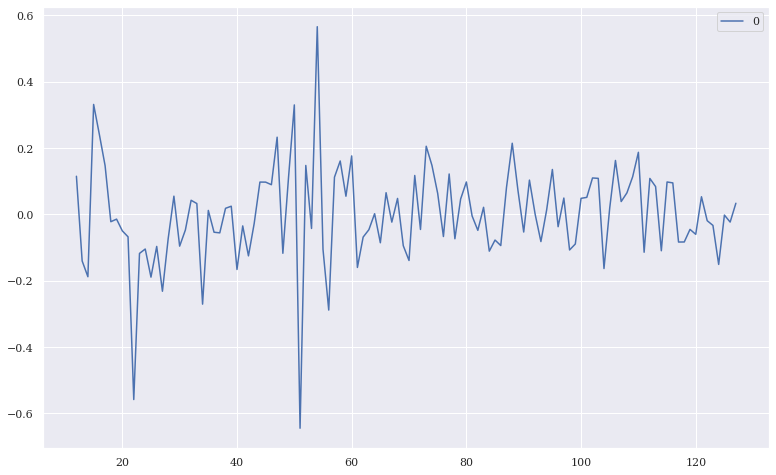

In [154]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

Plot histogram of residuals to check if normally distributed.

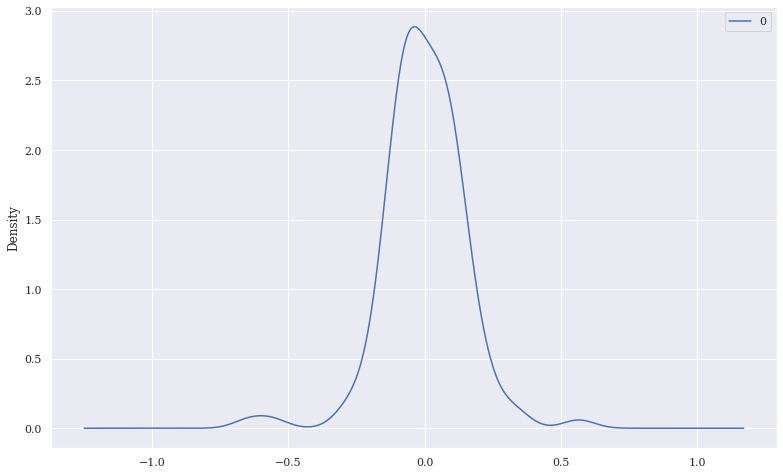

In [155]:
residuals.plot(kind='kde')

## Case Fatality Rates


In [156]:
from scipy import stats
import statsmodels.api as sm

CFR_df = df.groupby('location')[['total_cases','total_deaths',
                                   'prevalence','population']].last()
CFR_df = CFR_df[(CFR_df['total_cases']>0) & (CFR_df['total_deaths']>0)]
CFR_df['log_cases'] = np.log10(CFR_df['total_cases'])
CFR_df['log_deaths'] = np.log10(CFR_df['total_deaths'])
CFR_df['CFR'] = CFR_df['total_deaths']/CFR_df['total_cases']
CFR_df

,total_cases,total_deaths,prevalence,population,log_cases,log_deaths,CFR
location,,,,,,,
Afghanistan,33594.0,936.0,0.000863,38928341.0,4.526262,2.971276,0.027862
Albania,3038.0,81.0,0.001056,2877800.0,3.482588,1.908485,0.026662
Algeria,16879.0,968.0,0.000385,43851043.0,4.227347,2.985875,0.057349
Andorra,855.0,52.0,0.011066,77265.0,2.931966,1.716003,0.060819
Angola,353.0,19.0,0.000011,32866268.0,2.547775,1.278754,0.053824
...,...,...,...,...,...,...,...
Venezuela,7693.0,71.0,0.000271,28435943.0,3.886096,1.851258,0.009229
Western Sahara,519.0,1.0,0.000869,597330.0,2.715167,0.000000,0.001927
Yemen,1297.0,348.0,0.000043,29825968.0,3.112940,2.541579,0.268311


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


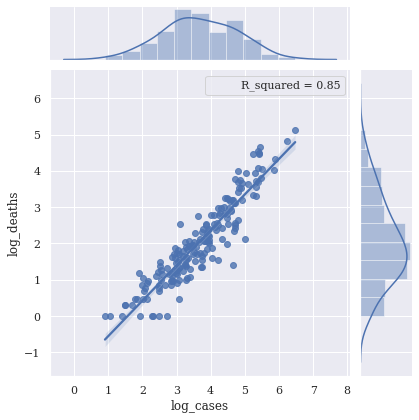

In [157]:
def R_squared(x, y):
    return stats.pearsonr(x, y)[0] ** 2

sns.jointplot(x='log_cases', y='log_deaths', data=CFR_df, 
                    stat_func=R_squared, kind='reg')
plt.show()

In [158]:
results = sm.OLS(endog=CFR_df['total_deaths'], exog=CFR_df[['total_cases']], 
                 missing='drop').fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:           total_deaths   R-squared (uncentered):                   0.870
Model:                            OLS   Adj. R-squared (uncentered):              0.870
Method:                 Least Squares   F-statistic:                              1222.
Date:                Thu, 09 Jul 2020   Prob (F-statistic):                    1.12e-82
Time:                        11:24:43   Log-Likelihood:                         -1800.4
No. Observations:                 183   AIC:                                      3603.
Df Residuals:                     182   BIC:                                      3606.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [159]:
results = sm.WLS(endog=CFR_df['total_deaths'], exog=CFR_df[['total_cases']], 
                 weights=CFR_df['population'], missing='drop').fit()
print(results.summary())

                                 WLS Regression Results                                
Dep. Variable:           total_deaths   R-squared (uncentered):                   0.944
Model:                            WLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              3025.
Date:                Thu, 09 Jul 2020   Prob (F-statistic):                   6.54e-115
Time:                        11:24:43   Log-Likelihood:                         -2058.1
No. Observations:                 182   AIC:                                      4118.
Df Residuals:                     181   BIC:                                      4121.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------